In [2]:
# Import the required modules
from IPython.display import clear_output
import PIL.Image
from io import BytesIO
import IPython.display

import cv2
import time
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
# UTILITY FUNCTIONS

In [169]:
#Use 'jpeg' instead of 'png' (~5 times faster)
def showarray(a, fmt='jpeg'):
    a = cv2.resize(a, (600 , 300))
    if len(a.shape) is 3:
        a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

In [73]:
def get_frame(cam):
    # Capture frame-by-frame
    ret, frame = cam.read()
    if not ret:
        raise KeyboardInterrupt()
    
    #flip image for natural viewing
    #frame = cv2.flip(frame, 1)
    
    return frame

In [74]:
# PROCESS FUNCTIONS

In [75]:
def generate_LUT(gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    def adjust_gamma(image):
        # apply gamma correction using the lookup table
        return cv2.LUT(image, table)
    return adjust_gamma

In [76]:
def DoG(frame, s=1, stride=0):
    #run a 5x5 gaussian blur then a 3x3 gaussian blr
    sB = (s+1+stride)*2+1
    sS = (s)*2+1
    blurB = cv2.GaussianBlur(frame,(sB,sB),0)
    blurS = cv2.GaussianBlur(frame,(sS,sS),0)

    return blurB - blurS

In [98]:
def Unwarp(frame):
    pts_src = np.array([[67, 0], [63, 856], [1552, 856],[1500, 0]])
    pts_dst = np.array([[0, 0],[0, 856],[1552, 856],[1552, 0]])

    h, status = cv2.findHomography(pts_src, pts_dst)
    frame_out = cv2.warpPerspective(frame, h, (frame.shape[1],frame.shape[0]))
    return frame_out[:, 200:1400]

In [99]:
adjust_gamma = generate_LUT(5)
se_c = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
se_vl = np.array([[0,1,0],[0,1,0],[0,1,0]], np.ubyte)
def process(frame_in):
    frame_out = cv2.cvtColor(frame_in, cv2.COLOR_BGR2GRAY)
    frame_out = cv2.equalizeHist(frame_out)
    frame_out = adjust_gamma(frame_out)
    frame_out = DoG(frame_out, 1, 1)
    frame_out = cv2.morphologyEx(frame_out, cv2.MORPH_OPEN, se_c, iterations=1)
    frame_out = cv2.morphologyEx(frame_out, cv2.MORPH_OPEN, se_vl, iterations=2)
    frame_out = Unwarp(frame_out)
    return frame_out

In [100]:
# Work area

In [172]:
input_file_path = 'bandicam 2018-10-24 10-51-31-769.mp4'
vid = cv2.VideoCapture(input_file_path)

In [173]:
# Seek needed frame
vid.set(cv2.CAP_PROP_POS_FRAMES,470)
frame = get_frame(vid)

In [174]:
try:
    while(True):
        t1 = time.time()
        
        # Capture frame-by-frame
        frame = get_frame(vid)

        # Convert the image from OpenCV BGR format to matplotlib RGB format
        # to display the image
        showarray(process(frame))
        t2 = time.time()

        print('%f FPS' % (1/(t2-t1+1e-07)))
        # Display the frame until new frame is available
        clear_output(wait=True)
except KeyboardInterrupt:
    vid.release()
    print('Stream stopped')

Stream stopped


In [69]:
# TEST

In [105]:
frame.shape

(856, 1552, 3)

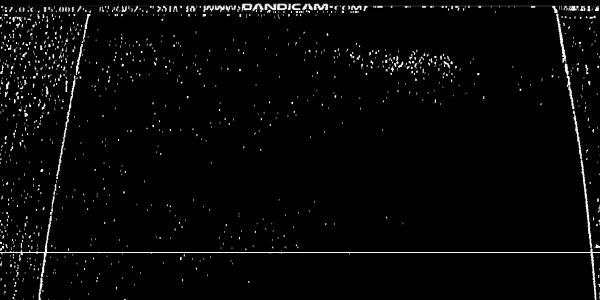

In [182]:
#Process frame
frame_p = process(frame)
#Get scan line
scan_line_h = 720
scan_line = frame_p[scan_line_h,:]
#Vis
frame_p_im = cv2.line(frame_p.copy(), (0,scan_line_h), (1552,scan_line_h), (255,))
showarray(frame_p_im)

In [329]:
# Find first peaks from center
# Find peaks
bins_count = 50
bin_width = round(len(scan_line)/bins_count)
bin_threshold = 800
scan_bins = sum(split(scan_line, bins_count), 1) # Grouped in 50 bins
scan_bins_peaks = where(scan_bins>bin_threshold)[0]
# Break peaks indexes to left an right from center
# And get peaks nearest to center
center_bin = round(bins_count/2)
left_peak = int(scan_line_peaks[scan_bins_peaks <= center_bin][-1]*bin_width-bin_width/2)
right_peak = int(scan_line_peaks[scan_bins_peaks > center_bin][0]*bin_width+bin_width/2)

# Get proposed plate line
scanned_line = frame[scan_line_h,left_peak:right_peak,:]

# Calculate various conditions
cavity_width = right_peak-left_peak
cavity_weight = sum(frame_p[scan_line_h,left_peak:right_peak])

In [ ]:
def scanLine(frame, scan_line_h = 720):
    #Get full frame scan line
    scan_line = frame_p[scan_line_h,:]

    # Find first peaks from center
    # Find peaks
    bins_count = 50
    bin_width = round(len(scan_line)/bins_count)
    bin_threshold = 800
    scan_bins = sum(split(scan_line, bins_count), 1) # Grouped in 50 bins
    scan_bins_peaks = where(scan_bins>bin_threshold)[0]
    # Break peaks indexes to left an right from center
    # And get peaks nearest to center
    center_bin = round(bins_count/2)
    left_peak = scan_line_peaks[scan_bins_peaks <= center_bin][-1]*bin_width
    right_peak = scan_line_peaks[scan_bins_peaks > center_bin][0]*bin_width

    # Get plate scan line
    scan_line = frame[scan_line_h,left_peak:right_peak+1,:]

    # Calculate various conditions
    cavity_width = right_peak-left_peak
    cavity_weight = sum(frame_p[scan_line_h,left_peak:right_peak+1])